# 2. Thermodynamics (i)

The gas we were thinking about in the previous lecture must satisfy conservation laws: Conservation of mass $m_a$, momentum $m_a[u, v, w]^T=m_a\mathbf{u}$ and energy $E$[^fnfd], which give us extremely powerful tools to predict the evolution of the atmospheric gas. Therefore, a lot of atmospheric science boils down to studying flows of mass, momentum and energy through the atmosphere. In the next two lectures, we will use simplified versions of the vertical momentum and energy flows, **to work towards the simplest possible model of the troposphere's vertical structure.** That is, we will study the globally (and decadally) averaged atmosphere - the atmosphere that sets our global climate. As we will see in the next lecture, even smaller, local phenomena that determine the weather are often studied as "perturbations" to this basic, vertical structure.

Because the energy flows in the atmosphere are driven by solar radiation, we can only truly understand them once we have studied radiation in module 6[^fnclim]. But we can already get pretty accurate vertical profiles if we take the energy supply for granted for a moment, and just focus on the consequences.

Along the way, we will have to make many definitions of different thermodynamic variables (mostly energies, entropies and moistures). Remembering, understanding and distinguishing between these is hard and tedious [^fnlec], so we will try to present them in service of our goal of understanding the atmosphere's vertical structure. However, mastering this "grammar" is essential to speak the language of atmospheric science.

```{note} Questions you should be able to answer at the end of this lecture:
   - Why does the troposphere's pressure drop off with height the way it does?
   - What types of energy does an atmospheric air parcel contain?
   - Why do we rather use enthalpy, rather than internal energy, for our calculations of energy exchange?
   - Why do dry adiabatic parcels lifted from the surface generally fall back down?
   - Can I read a thermodynamic (skew T-log p) diagram?
```
[^fnfd]: You can choose to derive and study those in depth in the course on [geophysical fluid mechanics](https://studyhandbook.wur.nl/modules/HWM23806?type=Cursory)
[^fnclim]: Therefore, we will return to the globally averaged vertical structure in our lectures on climate, at the end of the course
[^fnlec]: This applies to lecturers of atmospheric science too :)

## The vertical structure of the troposphere

Below, you can see a plot of pressure and temperature with "geopotenial height"[^fngeo], from all radiosondes launched across the world, since 1947, up to November 2024[^fnigra]. Why do they look like this? Let's start with pressure, which is the simplest of the two.

[^fngeo]: we define this height more precisely below
[^fnigra]: these are compiled and quality-controlled by the [Integrated Global Radiosonde Archive (IGRA)](https://www.ncei.noaa.gov/products/weather-balloon/integrated-global-radiosonde-archive)

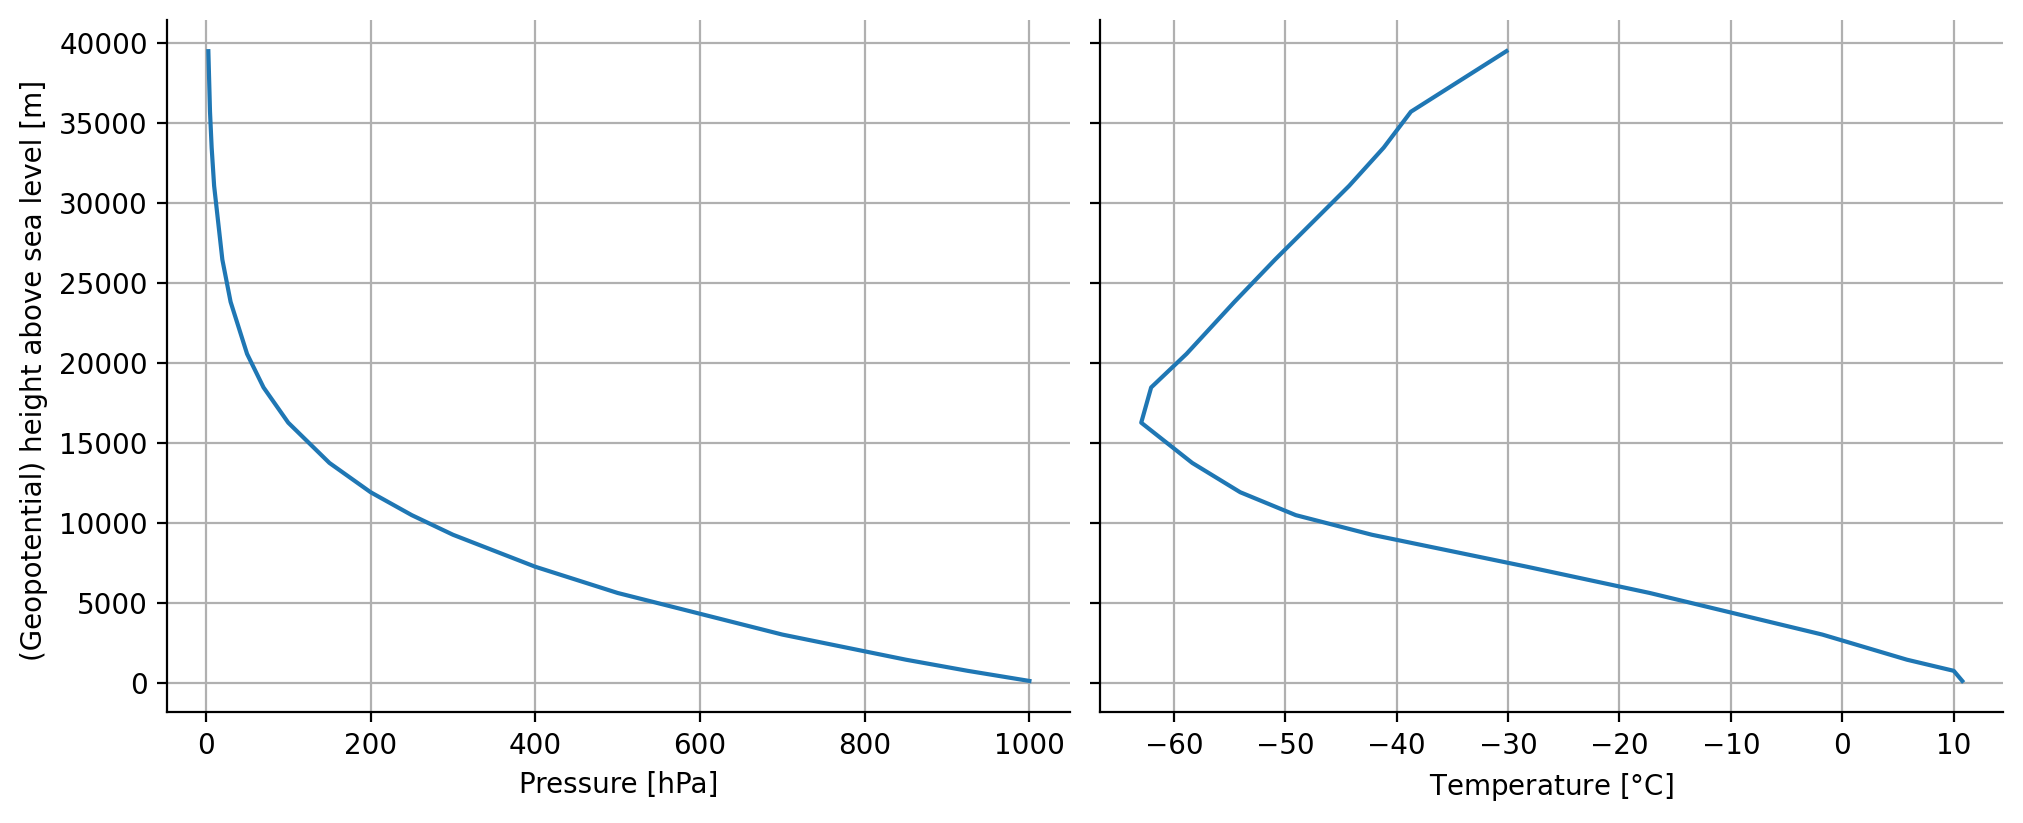

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
plt.style.use([pathlib.Path("./mplstyle/book")])

# Data from the 
# https://www.ncei.noaa.gov/data/integrated-global-radiosonde-archive/access/monthly-por/
# All monthly-averaged temperature, pressure and geopotential, from all stations, since the start of the record (1947)

# Pressure
df = pd.read_csv(r"data/ghgt_00z-mly.txt", sep=r'\s+', header=None).rename(columns={3: "pres", 4: "hgeo"})
df_pres = df[["pres", "hgeo"]].groupby(["pres"]).mean().loc[3:1000]

# Temperature
df = pd.read_csv(r"data/temp_00z-mly.txt", sep=r'\s+', header=None).rename(columns={3: "pres", 4: "temp"})
df_temp = df[["pres", "temp"]].groupby(["pres"]).mean().loc[3:1000]

# Temperatures are stored in tenths of a deg C, so they need to be divided by 10 and converted to Kelvin for later calculations:
df_temp['temp'] = df_temp['temp'] / 10 + 273.15

# Set the height coordinates of temperature to the height coordinates of pressure
df_temp = pd.concat([df_pres, df_temp], axis=1)

# Make pressure just another column in df_pres
df_pres = df_pres.reset_index()

# Store as an xarray dataset
ds_temp = df_temp.to_xarray().swap_dims({'pres':'hgeo'})
ds_temp = ds_temp.reindex(hgeo=list(reversed(ds_temp.hgeo)))
ds_temp.to_netcdf(r"data/ptmean.nc", 'w')

# Plot
fig, axs = plt.subplots(ncols=2, sharey=True)
axs[0].plot(df_pres['pres'], df_pres['hgeo'])
axs[0].set_xlabel('Pressure [hPa]')
axs[0].set_ylabel('(Geopotential) height above sea level [m] ')

axs[1].plot(df_temp['temp'] - 273.15, df_temp['hgeo'])
_=axs[1].set_xlabel(r'Temperature [$\degree$C]')

## Pressure - the force balance of hydrostatic equilibrium

In the global average, there cannot be vertical motion, unless the atmosphere is expanding into space. And it isn't, for almost all space and time scales we consider in this course: The globally averaged atmosphere, at any vertical level, is *static*, and is thus also not accelerating vertically - $\frac{dw}{dt}=0$. Therefore, if we look at Newton's second law ($\sum_iF_i/m= \frac{dw}{dt}$), and apply it to a globally averaged slab in the atmosphere, we know that all the forces $F_i$ which act vertically on that slab, must add up to zero.

So which forces act on such a layer? In our static situation, only the gravitational weight of all the layers that lie on top of it, and the resulting pressure force $F_p = pA_l$ on the air in the layer (remember pressure $p$ is defined as a force $F_p$  per unit area $A_l$, $p=F_p/A_l$). And traveling upwards from the surface, there are less and less such layers left above us before we get to space, so pressure decreases with height, as the left plot above shows. More precisely, for two levels separated by an infinitesimal vertical distance $dz$, the dropoff in pressure force $-dpA_l$ between the two levels must be equal to the weight of the layer in between $m_lg$:

**Need figure to support this**

$$
  F = -m_lg - dpA_l = m \frac{dw}{dt} = 0.
$$

Taking $m_l=\rho V_l=\rho A_l dz$ and treating $A_l$ and $g$ as constants[^fnglob], we divide by $A$ to get the force balance per unit area:

$$
  -\rho g dz + dp = 0,
$$

Or more generally[^fnpart]

$$
  \frac{\partial p}{\partial z} = -\rho g.
$$ (hyd-stat)

Eq.{eq}`hyd-stat` is called the hydrostatic equation. It is the first equation we derive, because it is the strongest force balance present in the atmosphere. Therefore, deviations from hydrostatic balance are usually quite small, even in weather systems and individual thunderstorms, where there can be large vertical air acceleration! All these motions are due to forces much smaller than those that make up hydrostatic balance. In other words, almost everywhere and always, measuring the pressure equals measuring the weight of the air column above you.

With the hydrostatic equation, we can derive a pretty accurate model for the pressure profile plotted above. For that, we have to integrate eq.{eq}`hyd-stat`. And to do that, we choose to re-express $\rho$ in terms of $p$ with the gas law $p = \rho R_d T_v$. I.e. inserting $\rho=\frac{p}{R_dT_v}$ in eq.{eq}`hyd-stat` and integrating between two arbitrary levels 0 and 1 gives:

$$
  \frac{\partial p}{\partial z} & = -\frac{pg}{R_dT_v} \\
  \frac{\partial p}{p} & = -\frac{g}{R_dT_v}\partial z \\
  \int_{p_0}^{p_1} \frac{d p}{p} & = -\frac{g}{R_d}\int_{z_0}^{z_1}\frac{1}{T_v} dz \\
  \ln p_1 - \ln p_0 & = -\frac{g}{R_d}\int_{z_0}^{z_1}\frac{1}{T_v} dz
$$

We cannot integrate the right-hand side, because we have not yet discussed how $T_v$ depends on $z$ (that's the next section). However, if we make life easy by removing $T_v$'s height-dependence, and instead assume $T_v$ is equal to its weighted vertical average between the two levels $\overline{T_v}$[^fnisot], then we can integrate, and we get something called the *hypsometric equation*:

$$
  \ln p_1 - \ln p_0 & = -\frac{g}{R_d\overline{T_v}}(z_1 - z_0) \\
  p_1 & = p_0 e^{\frac{z_1-z_0}{H}}.
$$ (hypso)

Here, we have defined the *scale height*

$$
  H = \frac{R_d\overline{T_v}}{g},
$$

which is the e-folding height of pressure. To get our desired model of $p$ throughout the vertical, we take level 0 in eq. {eq}`hypso` to be the surface and level 1 to be any level in the atmosphere:

$$
  p = p_0 e^{-z/H}.
$$ (phydro)

Knowing the surface pressure $p_0$ and estimating $\overline{T_v}\approx \overline{T} \approx -43 ^{\circ}$C between the surface and the highest level in the radisonde archive (40 km, i.e. we assume the atmosphere is *isothermal*), eq.{eq}`phydro` models the observed pressure profile throughout the entire atmosphere pretty well (orange line below).

[^fnglob]: In our global view, $A_l = 4\pi(R_e + z)^2$ for a level $R_e + z$ from the centre of the Earth ($R_e$ is Earth's radius). Similarly, from Newton's general law of gravity, $F_g = m_lG\frac{M}{(R_e+z)^2} = m_lg$ (i.e. $g=\frac{GM}{(R_e+z)^2}$, where $M$ is the mass of Earth, and $G$ the gravitational constant). I.e. both $A_l$ and $g$ depend on $(R_e+z)^2$, and are not entirely constant with height. Fortunately, since $R_e=6371$ km, while the troposphere is roughly 10 km deep, the assumption $(R_e+z)^2 = R_e^2$ is still accurate in the troposphere to within $\frac{z^2}{(R_e+z)^2} = \frac{10^2}{(6371+10)^2} = 0.996$ - the error is less than 0.4%. Therefore, in this course we approximate $A_l = 4\pi R_e^2$ and $g=\frac{GM}{R_e^2}$.
[^fnpart]: We use partial differences ($\partial$) in this equation because pressure depends on more independent variables than $z$.
[^fnisot]: To be precise, we define $\overline{T_v} = \frac{z_1-z_0}{\int_{z_0}^{z_1}\frac{dz}{T_v}}$

Average temperature between 0 and 40 km altitude: -43 C
Scale height: 6736 m


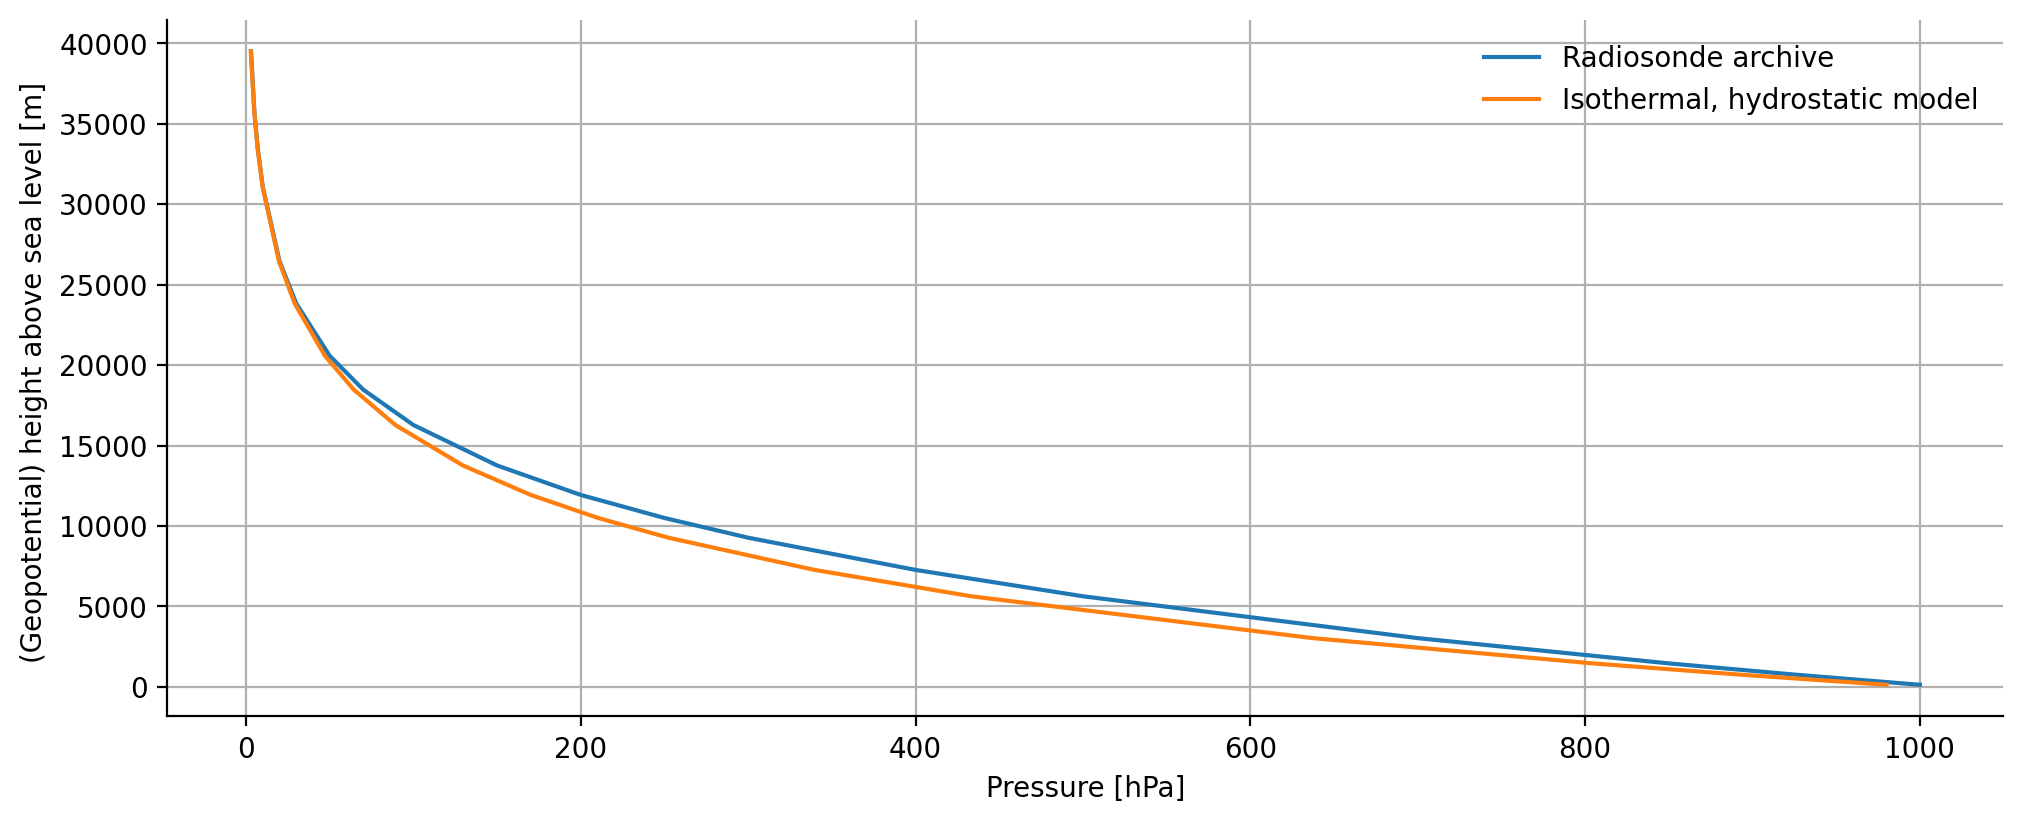

In [7]:
import numpy as np

grav = 9.81 # acceleration due to gravity [m/s^2]
Rd = 287.05 # Dry air gas constant [J/kg/K]

# Get the first pressure level in the radiosonde data, at 1000 hPa.
# This is not exactly the surface pressure, but it is a good "reference" to start comparing from
p0 = 1e3

# Compute average temperature over ~the troposphere
Tmn = ((ds_temp['hgeo'][-1] - ds_temp['hgeo'][0]) / (1./ds_temp['temp']).integrate('hgeo')).values
H = Rd*Tmn/grav # Scale height
pres_mod = p0*np.exp(-df_temp['hgeo'] / H)

fig, ax = plt.subplots(ncols=1)
ax.plot(df_pres['pres'], df_pres['hgeo'], label='Radiosonde archive')
ax.plot(pres_mod, df_pres['hgeo'], label='Isothermal, hydrostatic model')
ax.set_xlabel('Pressure [hPa]')
ax.set_ylabel('(Geopotential) height above sea level [m] ')
_=ax.legend()

print(r"Average temperature between 0 and 40 km altitude: %.0f C" %(Tmn-273.15))
print(r"Scale height: %.0f m" %H)

The model is not super in the troposphere, because eq. {eq}`hypso` will only give you the right pressure at the end points of the layer over which it is estimated (the surface and 40 km). In the troposphere, the average temperature ($-14 ^{\circ}$C) is quite a bit higher than the $\overline{T}$ we have used (and it is moister too, so $\overline{T_v}>\overline{T}$), so $H$ is larger and the pressure drops off less quickly than our first model. 

For a better model, it's clear that we need to let go of the assumption that the atmosphere is isothermal. Indeed, if we use eq. {eq}`hypso` to iterate our way through the vertical, using the observed $\overline{T}$ at each level, we get an almost exact reproduction of the observed pressure (orange line below). Let's therefore move toward understanding this vertical structure.

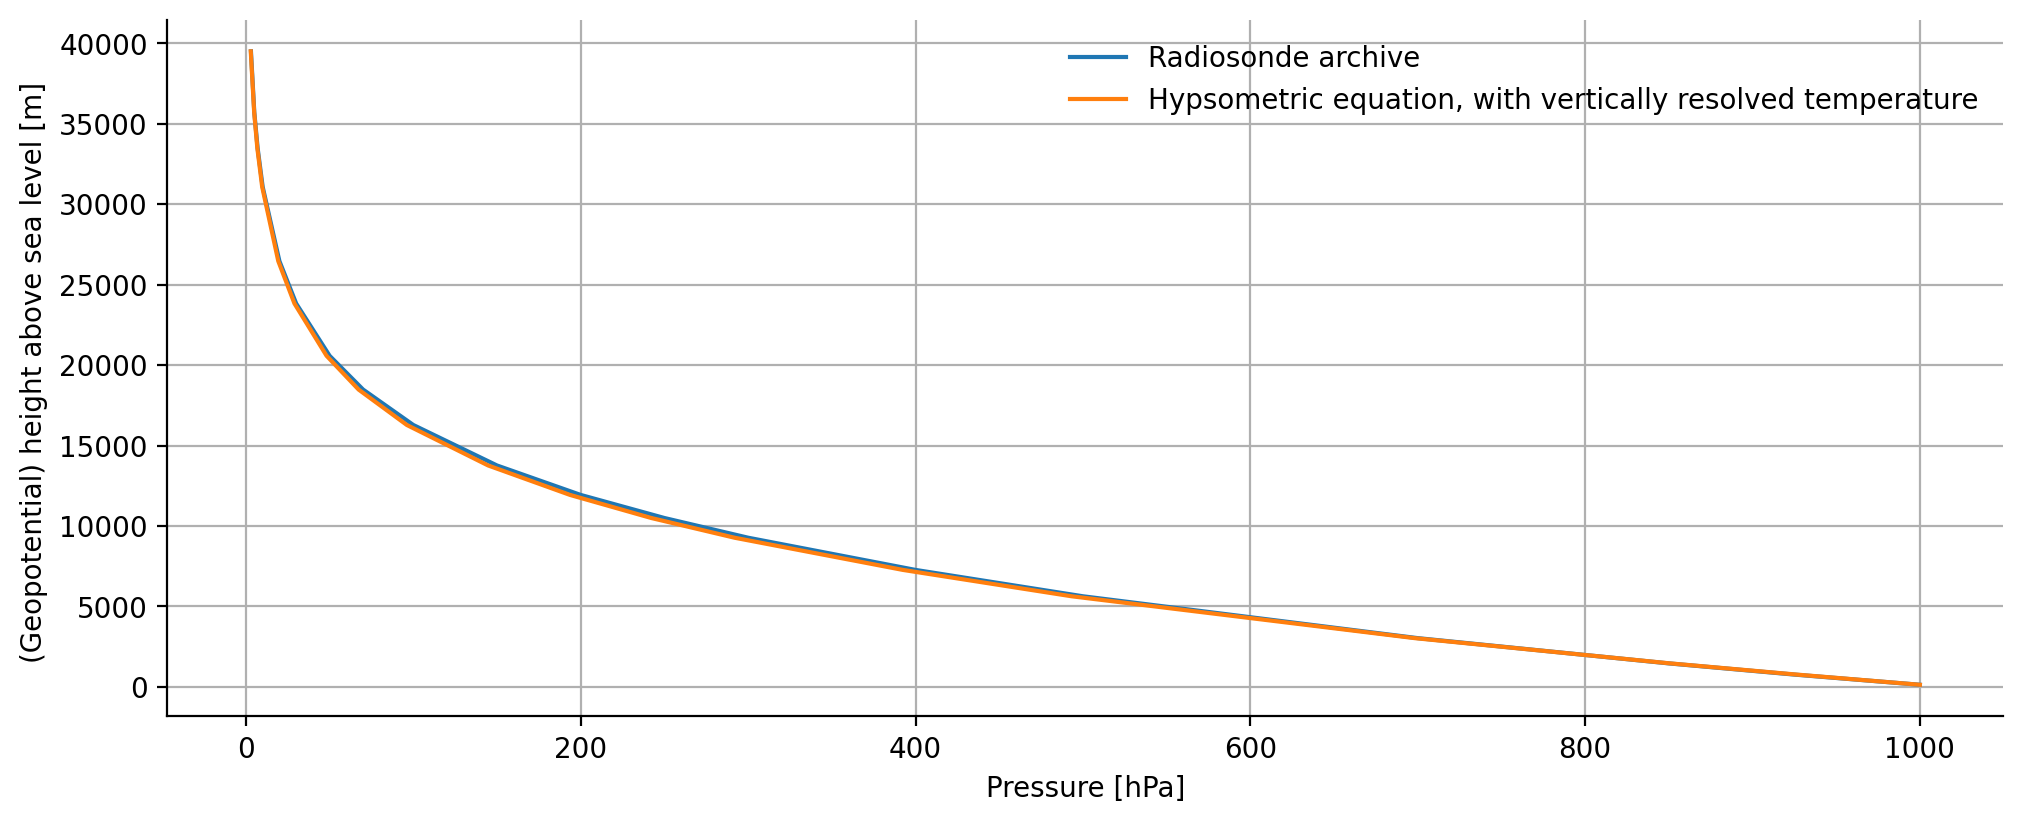

In [8]:
# Pressure from iterating through the hypsometric equation layer by layer:
pres_hyp = np.zeros(ds_temp.hgeo.size)
pres_hyp[0] = p0
for i in range(1, ds_temp.hgeo.size):
    pres_hyp[i] = pres_hyp[i-1]*np.exp(-grav/Rd/ds_temp['temp'][i]*(ds_temp['hgeo'][i] - ds_temp['hgeo'][i-1]))

fig, ax = plt.subplots(ncols=1)
ax.plot(df_pres['pres'], df_pres['hgeo'], label='Radiosonde archive')
ax.plot(pres_hyp, ds_temp['hgeo'], label='Hypsometric equation, with vertically resolved temperature')
ax.set_xlabel('Pressure [hPa]')
ax.set_ylabel('(Geopotential) height above sea level [m] ')
_=ax.legend()

## Temperature and atmospheric energetics

### Geopotential and the energetic interpretation of the hydrostatic balance
The hydrostatic law is a force balance, but we can re-interpret it in terms of energy. If we rewrite eq. {eq}`hyd-stat` as

$$
  gdz = -\frac{dp}{\rho},
$$ (geop-hyd)

we see that $gdz$ expresses a potential energy per unit mass[^fnmass]. More precisely, $gdz$ is the work that must be done to lift a 1 kg packet of air a distance $dz$ against Earth's gravitational field. It appears often enough that it's often lumped into a single quantity called *geopotenial* $\Phi$, i.e. $d\Phi = d (gz)$[^fngeop]. Eq. {eq}`geop-hyd` tells us that in hydrostatic balance, to give an air parcel $gdz$ of geopotential (in Joules per kilogram), we have to spend $-dp/\rho$. But what does that term mean? Clearly, it's some sort of pressure reduction $-dp$ in energy units ($J/kg$). But to understand it energetically, and to understand how this all relates to the temperature profile, we need to understand how changes in pressure in an air parcel relate to changes in its energy. And to do that, we need to think about what types of energy the parcel might have at all!

### Energy of an atmospheric air parcel
For a parcel of moist atmospheric air of volume $V$ with a fixed mass $m_a$ in motion, we might divide its energy $E$ per unit mass into the following contributions:

$$
E/m = gz + \frac{1}{2}u^2 + U/m
$$ (energy)

Where:
- $gz$ is the geopotential above $z=0$ (sea level)
- $\frac{1}{2}u^2$ is the kinetic energy above $u=0$ (air at rest), with $u=\sqrt{u^2+v^2+w^2}$ the wind speed. Although this kinetic energy is a key part of the weather we sense, its contribution to $E/m$ is actually really small[^fnwind], so we will ignore it in our discussion of energetics today. Of course, if we are interested in the kinetic energy in winds and turbulence, we cannot ignore it.
- $U/m$ measures the internal energy, including that of any potential water, in different phases. The presence of water, especially in different phases, has a large impact on $U/m$, which we will study in the next lecture. However, it is far easier to begin building our intuitition for this energy under the assumption that the atmosphere is dry. Then, we take $U/m=c_{v_d}T$ to essentially measure the kinetic energy of the random motion of the dry air molecules within the volume, which we discussed in [the previous lecture](sec:ideal-gases), above $T=0$ K (absolute zero). To scale this energy into temperature, we need the factor $c_{v_d}$, the heat capacity of the air in the parcel at constant volume (for dry air, $c_{v_d} \approx 717$ J/kg/K)[^fncv]. It is defined "at constant volume" to separate the internal energy from the parcel doing work through expansion (i.e. through changes in volume - see point 2. below).
<!-- - $L q_v - L_i q_i$ is the "latent" (or "hidden") energy stored in the parcel's water vapour, which is "released" when it changes phase. Specifically, $L_v q_v$ is the energy increase that would result from converting all the parcel's water vapour into liquid water (its efficiency is determined by the latent heat of vaporisation $L_v\approx 2.5 \times 10^6$ J/kg condensed water), and $-L_f q_i$ the energy increase from in turn losing some of that liquid water to $q_i$ kg ice/kg air (its efficiency is the smaller latent heat of fusion $L_f \approx 3.34\times 10^5$ J/kg frozen water). -->

We make these strange-looking "above reference state x" statements, because when we study energy flows, we always consider *changes* in energy relative to some reference state, and we will always have to be explicit about these states. To describe the vertical profile of $T$, we are clearly interested in the processes that can change the part of $E/m$ that relates to internal energy $U/m = c_{v_d}T$. For a little parcel in the atmosphere, there are really only three things that could do this:
1. We might exchange some of the air in the parcel with more/less energetic air, i.e. we could *advect* (or diffuse) air in and out. Let's denote that very generally as an energy source $Q_{a,U}$[^fnadv]
2. The parcel might lose internal energy by doing work $pdV$ through expansion ($dV$)
3. The parcel might heat/cool through radiation with a radiative heating rate of $Q_r$

That is, over a time increment $dt$, changes in specific internal energy $dU/m$ are:

$$
  dU/m = c_{v_d} dT = Q_{a,E}/m dt + Q_r/m dt - pdV/m
$$ (du)

And if we define $dq = Q_{a,E}/m dt + Q_r/m dt$, you might recognise that eq. {eq}`du` just states the first law of thermodynamics:

$$
  c_{v_d} dT + p dV/m = dq
$$

### The dry adiabatic lapse rate
How does eq. {eq}`du` relate to the temperature profile? Well, suppose first that the entire atmospheric temperature profile is determined by dry parcels moving up and down. This is a big assumption, and we have discussed no reason for why you should believe it. **Troposphere - means mixing. We should focus only on the troposphere** But if it's the case, then eq. {eq}`du` seems to offer a starting point, because if we can relate the processes on its right-hand side to the energy required to lift the parcel (i.e. to give it geopotential $gz$), then the left-hand side will tell us how much internal energy we have to spend to achieve that. But $gz$ does not appear in  eq. {eq}`du`. Clearly, we need to work on that right-hand side.

Let's first simplify things even more: We ignore the imposed heating rates $Q_{a,E}$ and $Q_r$. Now we are looking a parcel which can only undergo adiabatic processes - i.e. $dq=0$:

$$
  c_{v_d} dT = -p dV/m
$$ (first-law-dry-adiab)

In eq. {eq}`geop-hyd`, we found that $gdz = -dp/\rho$. So what we really want, is to relate the compression $-dp/\rho$ to the work $-pdV/m$. Let's do this. With the product rule, we know

$$
  d(pV) = Vdp + pdV.
$$

So, using the dry gas law $pV = mR_dT$ and the definition $\rho=m/V$:

$$
  p dV/m = d(pV)/m - Vdp/m = d(mR_dT)/m - Vdp/m = R_d dT - dp/\rho.
$$

In words, this relation says that the work done by a dry air parcel could come from raising its temperature, or reducing its pressure. And it is exactly this "pressure work" that eq. {eq}`geop-hyd` tells us we need to raise the potential energy of a parcel in hydrostatic equilibrium! So let's plug this expression into our energy equation eq. {eq}`first-law-dry-adiab` and rearrange:

$$
  c_{v_d} dT & = -R_d dT + dp/\rho \\
  (c_{v_d} + R_d) dT & = dp/\rho \\
  c_{p_d}dT & = dp/\rho. \\
$$ (first-law-enthalpy)

In the last line, we defined $c_{p_d} = c_{v_d} + R_d = 717 + 287 = 1004$ J/kg/K. $c_{p_d}$ is called the specific heat of dry air at constant pressure, because it converts to heat all the temperature changes in the parcel that occur while keeping the pressure constant, including those involved in doing work (the remaining change in energy due to changing the pressure is $dp/\rho$). $c_{p_d}T$ gives alternative measure for heat, called "enthalpy". And enthalpy is exactly the measure of heat we were looking for, because if we combine this equation with hydrostatic equilibrium eq.{eq}`geop-hyd` and multiply by $-1$:

$$
  -c_{p_d} dT = -dp/\rho = gdz.
$$ (dry-adiabat-energy)

In words, if we lift an air parcel up through a dry atmosphere without adding heat to it (i.e. we lift it adiabatically), then the (change in) enthalpy $-c_{p_t}dT$ is the heat we have to invest for the parcel to expand to the lower pressure and density (the pressure work $-dp/\rho$), and gain potential energy $gdz$. 

Put differently, dry adiabatic lifting in hydrostatic equilibrium is a process which conserves the sum of enthalpy and geopotential, which is called the "dry static energy" (DSE)[^fndse]:

$$
 d(c_{p_d}T + gz) & = 0 \\
 d (\text{DSE}) & = 0
$$ (dse)

From eq. {eq}`dry-adiabat-energy`, we can now define a "lapse rate" $\Gamma_d$ for the temperature of our parcel:

$$
  \frac{dT}{dz} = -\Gamma_d = -\frac{g}{c_{p_t}} = -9.81/1004 = -0.00978,
$$ (dry-adiabat)

$\Gamma_d$ is called the "dry adiabatic lapse rate". It predicts that to lift dry air parcels from the surface to the tropopause (around 15 km in the tropics), you'd have to reduce the temperature by around $-0.00978\times 15 \approx 150$ K. It gives us our first shot at a model for the vertical temperature profile - it's plotted below.

[^fngeop]: In our wish to interpret $\Phi$ as potential energy due to vertical displacement of air parcels, it matters that we take $g$ as a constant, because when it's not, the assumption $\Phi = \int_0^zgdz = g\int_0^zdz = gz$ breaks down. To circumvent this, it is common to define the "geopotential height" $Z = 1/g_0\int_0^zgdz = \Phi(z)/g_0$. $Z$ is the height to which a parcel is displaced if you give it the geopotential $\Phi$, and you assume it's experiencing the surface gravity $g_0$. It appeared e.g. on the y-axes in vertical profiles of pressure, because we went up to altitudes (40 km) where assuming $g=g_0$ is becoming untenable. That figure is a good example of why most real-world problems involving energy, express height in *geopotential height* $Z$, rather than in geometric height $z$. For most applications in this course, however, we stick with the assumption that $g=g_0$.
[^fnwind]: Consider, for example, a category 5 hurricane. To get that classification, it needs to have wind speeds of $>$70 m/s (252 km/hr!). That gives $\frac{1}{2}u^2 = 2450 J/kg$. If we were to take all that kinetic energy and dissipate it into internal energy, the temperature would rise by only $2450/c_{v_d}=2450/717\approx3.5$ K. Fortunately, most winds are even much weaker. So in this lecture, where we are studying an atmosphere with temperature differences between the surface and the tropopause of more than 100 K, we can safely ignore kinetic energy.
[^fnmass]: Energy per unit mass, in J/kg, is more precisely called "specific energy". Because we'll most often keep the mass that has the energy constant, we will usually just call it energy.
[^fncv]: More precisely, if the internal energy per unit mass is $u$, then to convert small changes in $u$ to small changes in $T$ we would write $du = \frac{du}{dT} dT$, identifying $c_v=\frac{du}{dT}$. It actually varies with temperature itself, but for this course we'll keep it fixed
[^fnadv]: The fluid dynamics course focuses in-depth on how to describe such advection mathematically
[^fndse]: This name actually refers to what the DSE *doesn't* measure: It's called "dry" because it excludes any energy stored in moisture, and "static" because it doesn't include any kinetic energy.

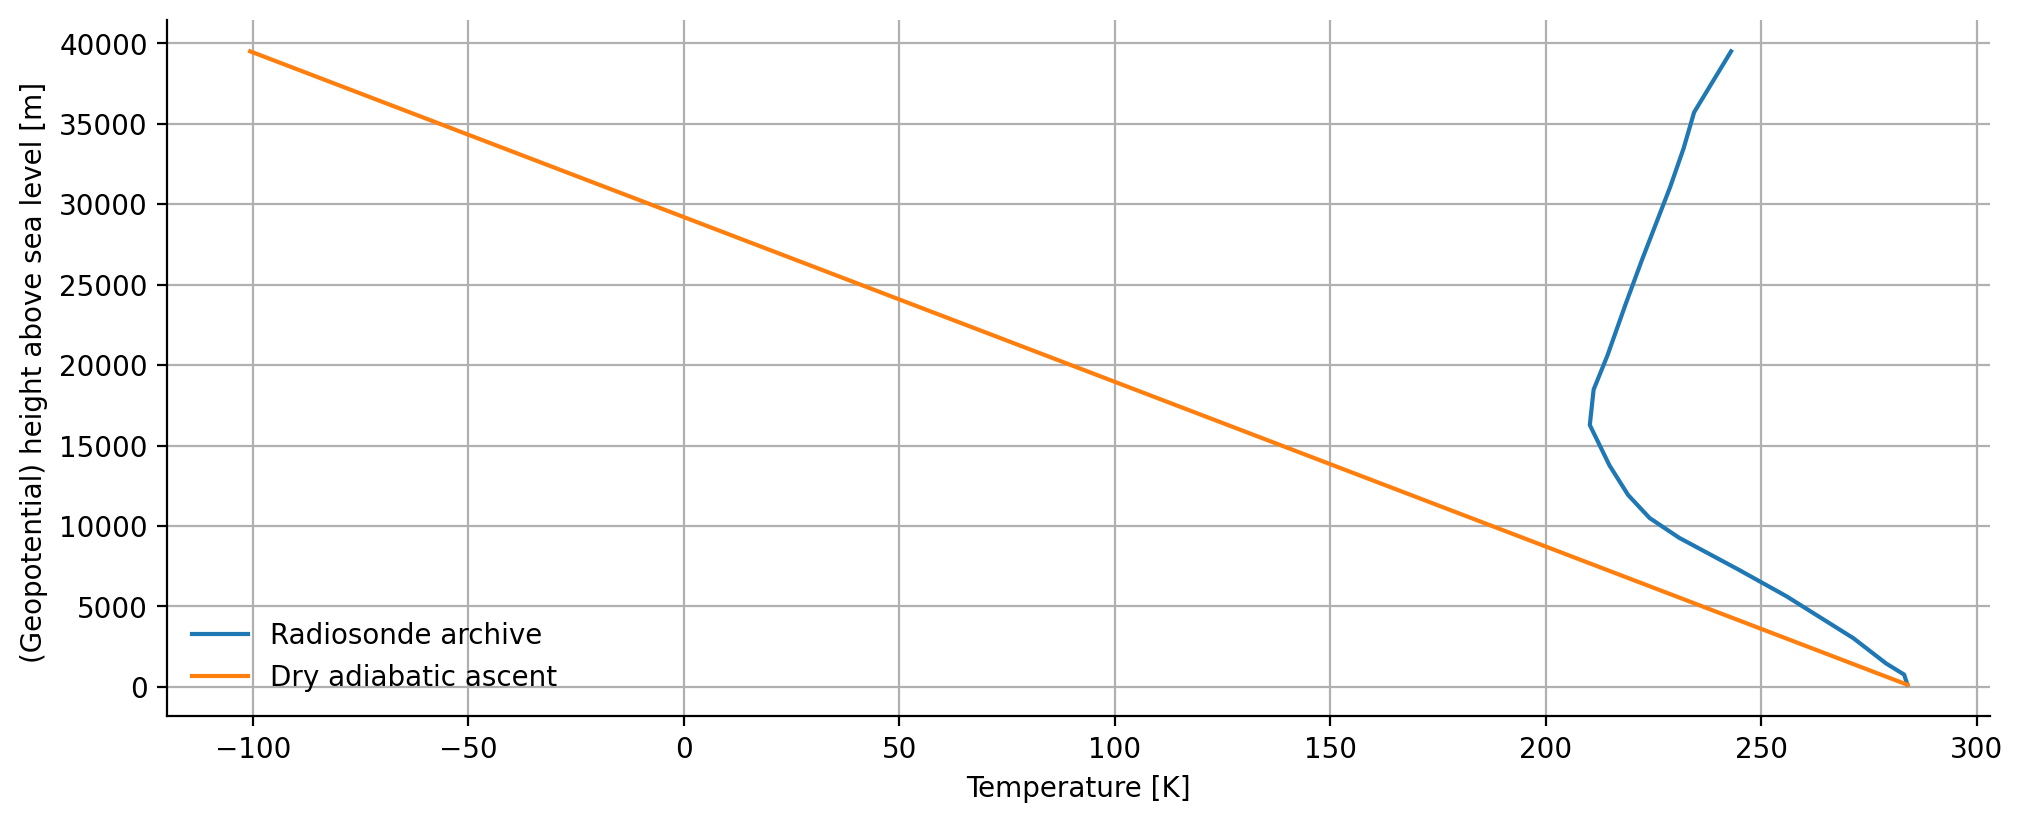

In [9]:
cpd = 1004. # Specific heat of dry air at constant pressure [J/kg/K]
Gamma_d = -grav/cpd

# Get the near-surface temperature from the radiosonde data
T0 = ds_temp['temp'][0]

# Temperature profile of dry adiabatic ascent from this level:
T_ad = T0 + Gamma_d*(ds_temp['hgeo'] - ds_temp['hgeo'][0])

# Temperature profile which accounts for buoyancy consumption
# (see https://www.romps.berkeley.edu/papers/pubdata/2017/leshouches/17leshouches.pdf section 1.7)
# T_b = T0*np.exp(-grav*ds_temp['hgeo']/cpd/300)

fig, ax = plt.subplots(ncols=1)
ax.plot(ds_temp['temp'], ds_temp['hgeo'], label='Radiosonde archive')
ax.plot(T_ad, ds_temp['hgeo'], label='Dry adiabatic ascent')
# ax.plot(T_b, ds_temp['hgeo'], label='Buoyancy-consuming ascent')
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('(Geopotential) height above sea level [m] ')
_=ax.legend()

That's not nothing, but it's also not fantastic. In Earth's troposphere, the temperature does drop off, but it does so less quickly than $-g/cp$. Worse, if we keep on lifting into the stratosphere, where the actual temperatures increase with altitude, we even get negative temperatures! So where did this go wrong? The main problem with our development so far, is that we never answered the question "why would the atmosphere take on the temperature profile of dry-adiabatically lifted parcels?" This problem has two sub-problems:
1) Why would parcels go up and down at all, and imbue the atmosphere with their characteristics?
2) Why would the energetics of moving parcels be governed by dry adiabatic energy exchange in perfect hydrostatic equilibrium?

We'll look at the first of these today, and the second tomorrow.

## Dry static stability

To deal with the first problem, let's write an actual equation of motion for that parcel we're trying to lift. To make that parcel move (without us artificially lifting it), we need it to accelerate vertically from rest. If it does, its force balance cannot reduce to hydrostatic equilibrium exactly. To discover why, let us write Newton's second law for the parcel (subscript $p$) more generally:

$$
  \rho_p\frac{dw_p}{dt} = -\frac{dp_p}{dz} - \rho_pg
$$ (par-hyd)

If we assume the environment around the parcel remains in hydrostatic equilibrium (which we *have* confirmed is reasonable, at least globally),

$$
\rho_e\frac{dw_e}{dt} = 0 = -\frac{dp_e}{dz} - \rho_eg,
$$ (env-hyd)

then subtracting eq. {eq}`env-hyd` from eq. {eq}`par-hyd` gives the equation of motion for the parcel, relative to the environment:

$$
\rho_p\frac{dw_p}{dt} = -\left(\frac{dp_p}{dz} - \frac{dp_e}{dz}\right) - \left(\rho_p - \rho_e\right)g,
$$

When lifting the parcel a distance $dz$ dry-adiabatically from the same pressure, temperature and density as the environment, the parcel does pressure work until $p_p(z) = p_e(z)$. So, $dp_p/dz = dp_e/dz$. However, $\rho_p$ and $\rho_e$ don't then generally have to be the same, i.e. the parcel doesn't have to be in hydrostatic equilibrium. Actually, we can write:

$$
\frac{dw_p}{dt} = - \frac{\rho_p - \rho_e}{\rho_p}g \equiv b,
$$

where we have defined the Archimedian buoyancy $b$ of the parcel. In words, this says that if we move our parcel upwards through a hydrostatic atmosphere and let it equilibrate to the new environmental pressure, it will accelerate upwards if its new density is lower than that of the environment. In our dry case where $p_e=p_p$, we can use the gas law to re-express $b$ in temperature differences:

$$
b = \frac{T_p - T_e}{T_e} ,
$$

That is, if at the new height $T_p > T_e$, the parcel will accelerate upwards. Warm air goes up.

However, when we lifted a parcel from the surface with the dry adiabatic lapse rate in the figure above, we found that at any point in the atmosphere, we were colder than the actual environmental profile, because our dry adiabatic profile loses temperature faster than the surrounding atmosphere. Mathematically:

$$
\frac{dT_p}{dz} & < \frac{dT_e}{dz}, \\
\Gamma_p & > \Gamma_e
$$

So, lifting our dry parcel adiabatically from the surface would immediately give it a negative buoyancy, and accelerate it back towards the surface. We can say that the global atmosphere is "statically stable" to vertical, adiabatic dry air perturbations. Clearly, its temperature profile cannot be explained by such perturbations.

## When is dry adiabatic thinking useful?

It would be fair to, at this point, question if we are on the right path to explain the vertical temperature structure of the atmosphere. However, the problem actually isn't the assumption that the atmosphere's temperature profile is set by vertical mixing of air parcels. As we will see in the next lecture, it is! The real issue is the second problem stated above: We've not considered all the sources that could heat a rising air parcel, and thus make it buoyant.

However, before we start to add these processes back in, let's ask if there are *any* regimes dominated by dry adiabatic lifting. In fact, there many of these: E.g. so-called buoyancy waves[^fngws], which spread from a dry perturbation as above like ripples on a pond. Or the atmospheric boundary layer. Below, we've plotted the vertical profile of DSE averaged over 1068 radiosondes dropped from an aircraft during a [field campaign over the tropical Atlantic in 2020](https://eurec4a.eu/). For the lowest portion of the atmosphere in this example, the *boundary layer* (below roughly $500$ m), the DSE *is* quite constant, and the temperature follows the dry adiabatic lapse rate quite well! Indeed, it is useful to think of the boundary layer as a layer which is formed by the vertical mixing of parcels which ascend and descend following nearly dry-adiabatic trajectories; we will study this in more detail in module 9.

**Use dry static stability to explain the structure of the mean BL. That is a dry proxy of what we will do moist for the entire atmosphere in the next lecture**

[^fngws]: Sometimes also called gravity waves

/Users/martinjanssens/opt/miniconda3/envs/metclim-jupyter-book/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


Number of sondes in dataset: 1068


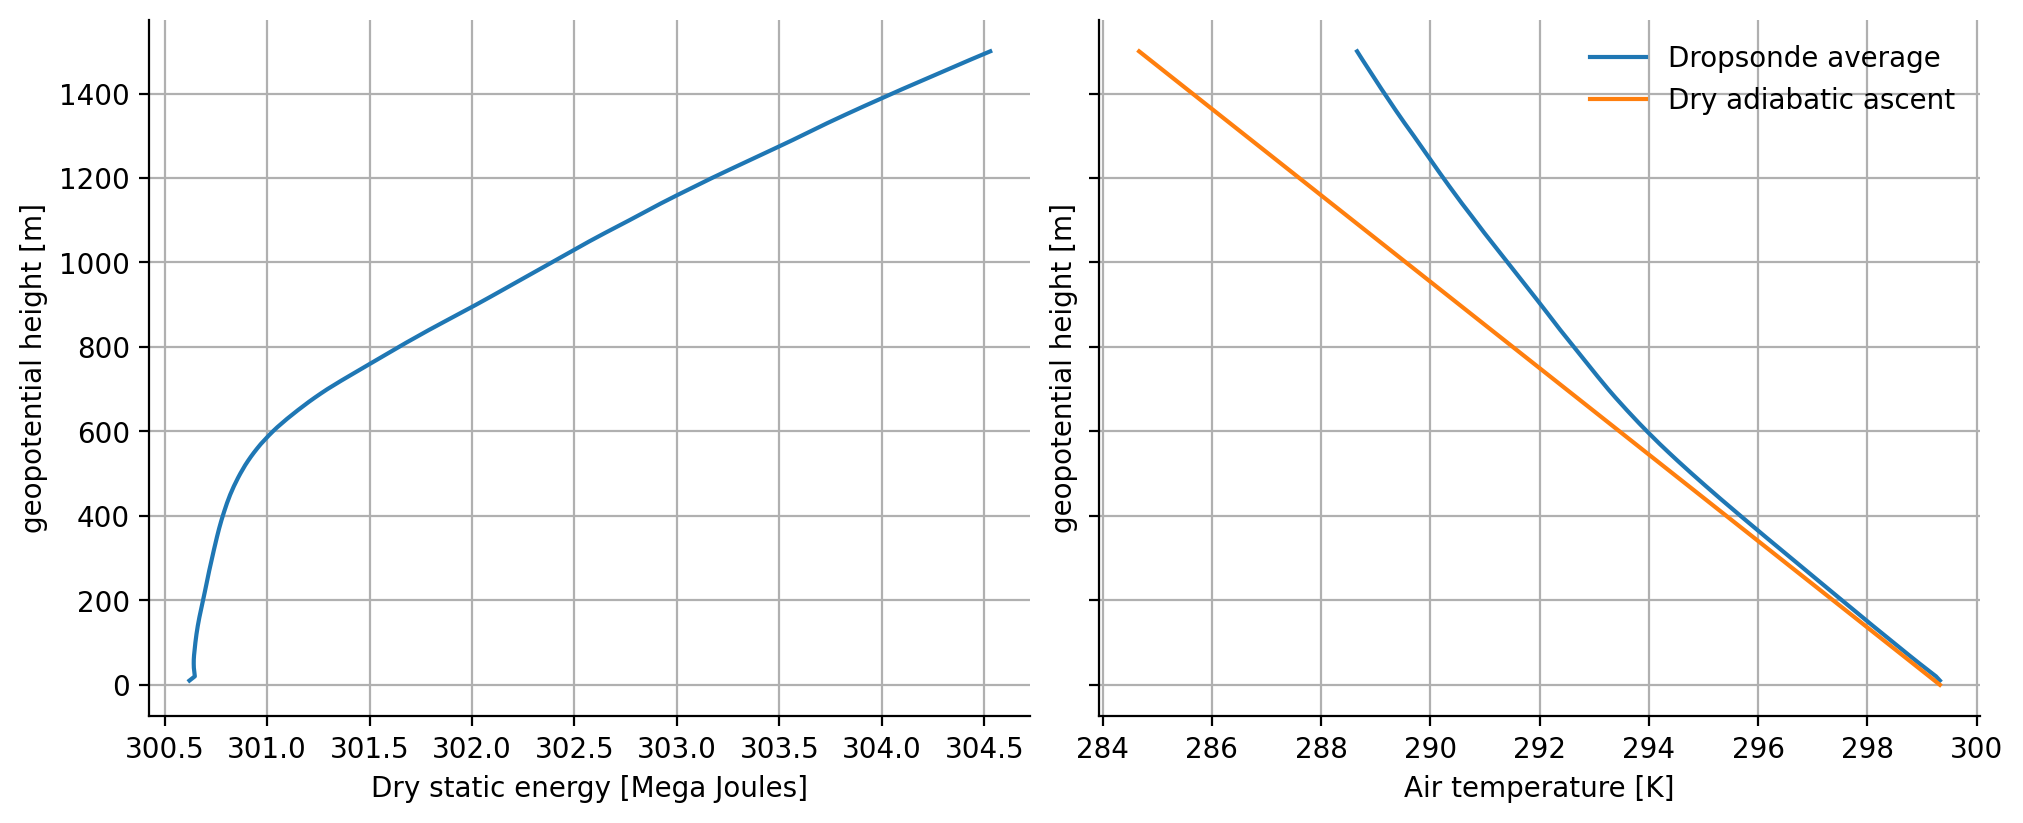

In [28]:
# Load the data - see https://howto.eurec4a.eu/dropsondes.html for details
import eurec4a
cat = eurec4a.get_intake_catalog()
ds_dropsondes = cat.dropsondes.JOANNE.level3.to_dask().sel(alt=slice(0,1500))

print('Number of sondes in dataset:', ds_dropsondes.sonde_id.size)
dse = (cpd * ds_dropsondes['ta'] + grav * ds_dropsondes['alt']) * 1e-3

# Average over all the sondes
dse_mn = dse.mean('sonde_id')
T_mn = ds_dropsondes['ta'].mean('sonde_id')

# Dry adiabatic temperature profile, from near the surface
T_ad = T_mn[1] - grav/cpd * ds_dropsondes['alt']

# Plot
fig, axs = plt.subplots(ncols=2, sharey=True)
dse_mn.plot(y='alt', ax=axs[0])
axs[0].set_xlabel('Dry static energy [Mega Joules]')

T_mn.plot(y='alt', ax=axs[1], label='Dropsonde average')
T_ad.plot(y='alt', ax=axs[1], label='Dry adiabatic ascent')
axs[1].set_xlabel('Air temperature [K]')
_=axs[1].legend()

## Potential temperature
So far, we have worked with energies and forces. These are intuitive quantities. However, atmospheric scientists also like to work with something called "potential temperatures". If both the atmosphere and parcels displaced through it, are in perfect hydrostatic equilibrium, potential temperatures do not tell us anything we cannot express with static energies. However, as we saw above, that assumption led us to ignore parcel buoyancy. Moreover, although they are a bit less intuitive, potential temperatures are used across the atmospheric sciences, and [especially in meteorology](https://doi.org/10.1175/BAMS-D-22-0013.1). Boundary layer meteorology is a great example. Therefore, we have to understand them too.

Let's go back to eq. {eq}`first-law-enthalpy`:

$$
  c_{p_d}dT = \frac{dp}{\rho}
$$

Instead of immediately relating this to the vertical structure with hydrostatic balance, let's try to just solve this, by eliminating $\rho$ with the gas law, and integrating from a reference pressure $p_0$ and a corresponding reference temperature $\theta$, to $p$ and $T$:

$$
  c_{p_d}dT & = \frac{dp}{p}R_dT \\
  \int_{\theta}^T\frac{dT}{T} & = \frac{R_d}{c_{p_d}} \int_{p_0}^p\frac{dp}{p} \\
  \ln T - \ln \theta & = \frac{R_d}{c_{p_d}} \left(\ln p - \ln p_0\right) \\
  \ln \frac{T}{\theta} & = \frac{R_d}{c_{p_d}} \ln \frac{p}{p_0} \\
  \frac{T}{\theta} & = \left(\frac{p}{p_0}\right)^{\frac{R_d}{c_p}} \equiv \Pi
$$ (theta-dev)

In the last line, we defined a quantity $\Pi$ called the "Exner function", so that:

$$
  \theta = \frac{T}{\Pi} = T\left(\frac{p_0}{p}\right)^{\frac{R_d}{c_p}}
$$

$\theta$ is the potential temperature. It measures the temperature of a dry air parcel, if it is adiabatically compressed or expanded from its current pressure $p$, to a reference pressure $p_0$. For the atmosphere, where pressure drops off strongly with height, we often consider air parcels from a particular level higher in the atmosphere, and ask "what would its temperature be, if we brought it adiabatically to the surface, thus compressing it to the surface pressure?" Therefore, although we are free to choose it, $p_0=10^5$ Pa[^fnpzero] across the atmospheric sciences. 

[^fnpzero]: This $p_0$ is not exactly the surface pressure, which is 101325 Pa for a standard atmosphere. But it's the closest round number.

## The skew T - ln p chart 
*Relate to dry adiabatic lapse rate?* Yes, through skew-T ln-P chart

Where $z$ was a natural vertical coordinate to interpret DSE, $\theta$ is a function of only $T$ and $p$, and not of $z$. This is because we didn't use hydrostatic balance to derive it, i.e. $\theta$ is conserved over more general adiabatic energy exchange. So, if we want to study changes in $T$ through $\theta$, our vertical coordinate must be $p$:

$$
T = \theta \left(\frac{p}{p_0}\right)^{\frac{R_d}{c_p}}
$$

We know very well by now that $p$ and $z$ are tightly coupled through hydrostatic balance (see the hypsometric equation eq. {eq}`hypso`): 

$$
\ln p_1 - \ln p_0 = -\frac{g}{R_d\overline{T}}(z_1 - z_0)
$$

So, its very common to reinterpret the vertical coordinate $z$ in terms of pressure $p$, or to get a coordinate which is linearly proportional to $z$, $\ln p$. To convince ourselves that nothing has really changed, let's look at the vertical temperature profile as a function of $\ln p$, by making the y-axis scale logarithmic. Let's also add a few lines of constant $\theta$ (i.e. lines describing dry adiabatic energy exchange).

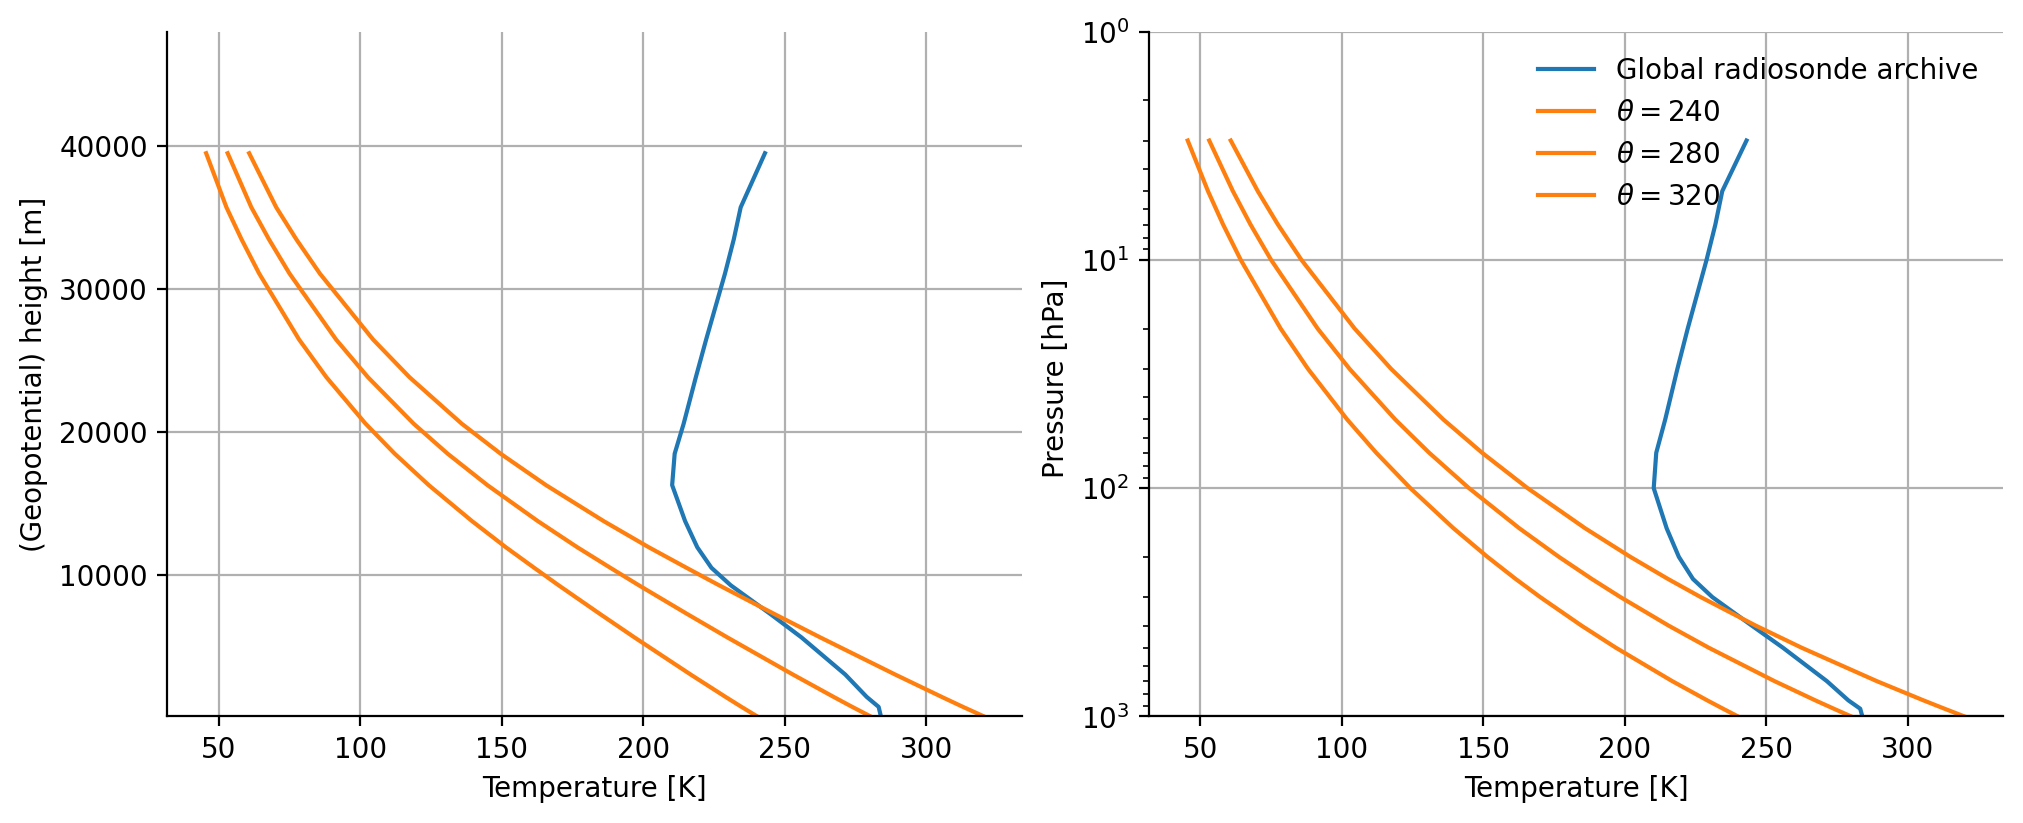

In [106]:
pref = 1e3 # Reference pressure, in hPa (which is what we have in ds_temp)

# Range over which to plot lines of constant theta
theta = np.arange(240,360,40)

fig, axs = plt.subplots(ncols=2)

# In z coordinates
axs[0].plot(ds_temp['temp'], ds_temp['hgeo'])
for i in range(len(theta)):
    axs[0].plot(theta[i]*(ds_temp['pres']/pref) ** (Rd/cpd), ds_temp['hgeo'], c='C1')
axs[0].set_ylim(100,48e3)
axs[0].set_xlabel('Temperature [K]')
axs[0].set_ylabel('(Geopotential) height [m]')

# In ln p coordinates
axs[1].plot(ds_temp['temp'], ds_temp['pres'], label='Global radiosonde archive')
for i in range(len(theta)):
    axs[1].plot(theta[i]*(ds_temp['pres']/pref) ** (Rd/cpd), ds_temp['pres'], label=r'$\theta = %.0f$'%theta[i], c='C1')
axs[1].set_yscale('log')
axs[1].set_ylim(1e3,1)
axs[1].set_xlabel('Temperature [K]')
axs[1].set_ylabel('Pressure [hPa] ')

_=axs[1].legend()

Indeed, the two figures are similar. Note that lifting dry adiabatically along lines of constant $\theta$ will never lead to negative temperatures, in contrast to what happened when we tried to conserve DSE along our ascent. Since we derived $\theta$ directly from conservation energy (eq. {eq}`theta-dev`), it is clear that negative temperatures came from the additional assumptions (regarding hydrostatic balance) we made when deriving conservation of DSE. This is an advantage of using $\theta$. However, because we did not add any new physics, it still is a poor model of the vertical structure of the globally averaged atmosphere.

Because temperature always reduces with $z$ (or $\ln p$), we now need a very long x-axis to plot the entire temperature range for some of these $\theta$ trajectories. This obscures smaller changes. Therefore, it's common to just rotate the lines of constant temperature (the vertical lines in the figure above), usually by around 45 degrees, to make the *actual* temperature change with height look vertical. Such a plot is called a skew T - log p chart. We've drawn such a plot below, using the python package [Metpy](https://unidata.github.io/MetPy/latest/index.html).

Text(0, 0.5, 'Pressure [hPa]')

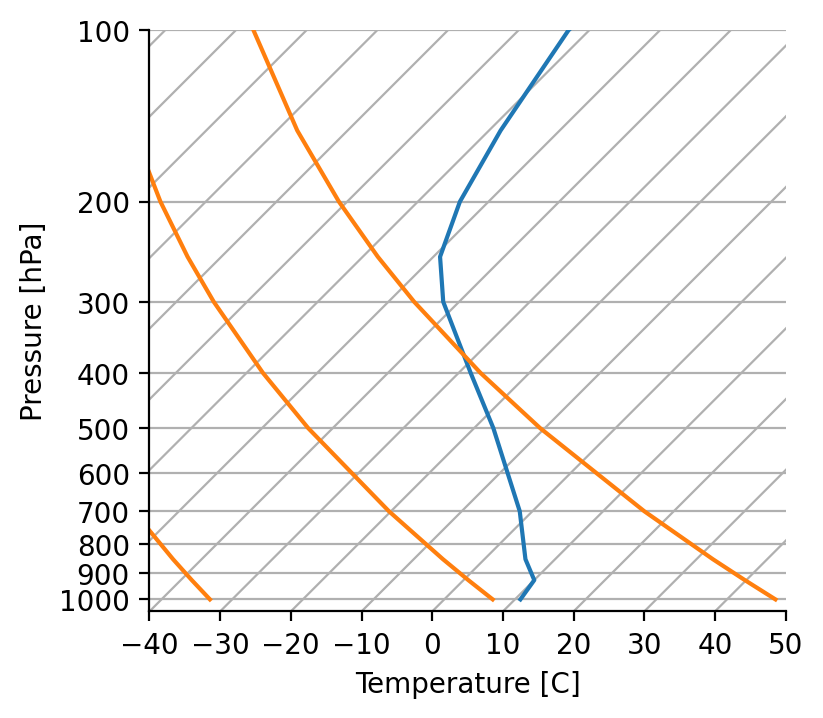

In [98]:
from metpy.plots import SkewT

fig = plt.figure(figsize=(4,4))
skew = SkewT(fig, rotation=45)

skew.plot(ds_temp['pres'], ds_temp['temp']-273.15, label='Global radiosonde archive')
for i in range(len(theta)):
    skew.plot(ds_temp['pres'], theta[i]*(ds_temp['pres']/pref) ** (Rd/cpd) - 273.15, label=r'$\theta = %.0f$'%theta[i], c='C1')
skew.ax.set_xlabel('Temperature [C]')
_ = skew.ax.set_ylabel('Pressure [hPa]')

On this plot, one commonly refers to the skewed, constant temperature lines as "isotherms" and the orange lines of constant $\theta$ as "dry adiabats". It nicely shows that if you heat a surface parcel to 50$^{\circ}$C in the global atmosphere (where the surface temperature is around 15$^{\circ}$C), and let it rise dry adiabatically through the global atmosphere, it will become negatively buoyant $T_p<T_a$ at around 400 hPa, or 7200 m. Only air parcels from giant forest fires ever start with $T_p - T_a > 35^{\circ}$C. Yet we routinely find air parcels from the surface which reach into the stratosphere.

What are we missing? That will be the topic of the next lecture.

<!-- To include:

Enthalpy isolates changes in heat that occur at constant pressure, rather than at constant volume. Because it exposes the changes in pressure, and it is these giant changes in pressure in the atmosphere's vertical which determine so much of its structure, atmospheric scientists generally prefer to work with enthalpy over internal energy.

What would happen if we hadn't ignored the radiative heating?

Why is adiabatic a good assumption? -->

## Exercises (ideas)

### 1. A more intuitive interpretation of the scale height
Show that the scale height $H = M/\rho_0$, where $M$ is the mass of the atmosphere per square metre, and $\rho_0$ is the surface density. Hint: Use eq.{eq}`phydro`, and $M = \int_0^\infty \rho dz$. 

Solution: Rewrite eq. {eq}`phydro` with the gas law:

$$
  p & = p_0 e^{-z/H} \\
  \rho & = \rho_0 e^{-z/H}
$$

And insert in the mass expression:

$$
  M & = \int_0^\infty \rho_0 e^{-z/H} dz \\
  & = \left[ -\rho_s H e^{-z/H} \right]_{0}^{\infty} \\
  & = -\rho_s H \left(e^{-\infty} - e^{0} \right) \\
  & = \rho_s H
$$

So $H = M/\rho_s$, i.e. $H$ is the height that an isothermal atmosphere would have, if its density were equal to the surface density.

### 2. Preventing negative temperatures in dry adiabatic exchange
A parcel of dry air is lifted adiabatically a distance $dz$ in an atmosphere in hydrostatic equilibrium, i.e. $dp_e/dz = -\rho_eg$.

1) Show that if this parcel always equilibrates to the environmental pressure far from the parcel ($p_p = p_e$), but *not* necessarily to the environmental density ($\rho_p \neq \rho_e$), vertical changes in the parcel's Dry Static Energy, $d(DSE_p) = d(c_{p_d}T_p + gz) = -bdz$, with $b = g(\rho_e - \rho_p)/\rho_p$. Hint: Use the fact that for dry adiabatic energy exchange, $c_{p_d}dT = -dp/\rho$.
2) Derive a vertical temperature profile based on this equation, assuming that the environmental temperature is isothermal (always equal $T_e$).

Solution:
We follow the [lecture notes by David Romps, section 1.7](https://www.romps.berkeley.edu/papers/pubdata/2017/leshouches/17leshouches.pdf):
1) For the parcel, $d(c_{p_d}T_p) = dp/\rho_p$. Plug it in to the expression for DSE, and 
$$
d(DSE_p) & = c_{p_d}dT_p + gdz \\
         & = dp_p/\rho_p + gdz \\
         & = dp_e/\rho_p + gdz \\
         & = -gdz\rho_e/\rho_p + gdz \\
         & = -g\left(\rho_e/\rho_p - 1\right)dz \\
         & = -g\frac{\rho_e - \rho_p}{\rho_p}dz \\
         & = -bdz
$$
So in general, the dry static energy is *not* conserved for dry adiabatic lifting, but equal to minus buoyancy:

$$
 \frac{d(DSE)}{dz} = -b
$$

2) Because we are looking for a temperature profile, let's write the left-hand side in terms of $dT_p/dz$, and expand the right-hand side with the aim of introducing $T_p$ for $\rho_p$ there too:
$$
\frac{d}{dz}\left(c_{p_d}T_p + gz\right) & = -b \\
c_{p_d}\frac{dT_p}{dz} + g & = -g\frac{\rho_e - \rho_p}{\rho_p} \\
 & = -g\frac{\rho_e}{\rho_p} + g
$$
Here, we see that the factor $g$ cancels on both sides, giving:
$$
c_{p_d}\frac{dT_p}{dz} & = -g\frac{\rho_e}{\rho_p} \\ 
& = -g\frac{p_e/(R_dT_e)}{p_p/(R_dT_p)} \\
& = -g\frac{T_p}{T_e}
$$
Where we used the dry gas law, and $p_e = p_p$. This, we can rearrange and integrate:

$$
\int_{0}^z\frac{dT_p}{T_p} & = -\int_{0}^z\frac{g}{c_{p_d}T_e}dz' \\
\ln(T(z)) - \ln(T(0)) = -\frac{g}{c_{p_d}}\int_0^z \frac{dz'}{T_e}
$$

And if $T_e$ is constant with height, we can solve it analytically:

$$
\ln\frac{T(z)}{T(0)} & = -\frac{gz}{c_{p_d}T_e} \\
T(z) & = T(0)e^{-\frac{gz}{c_{p_d}T_e}}
$$

That model will never yield negative temperatures, and is thus a better statement of the dry adiabatic lapse rate than what is usually found in text books.